In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import norm

import os
import time
import itertools

from glove.model import *

# Combine data sets

In [2]:
# import data
df = pd.read_csv("data/MS008_processed_mono.csv")
df.sort_values(by=["Treatments", "Time"], inplace=True)

# fit gLV models

In [3]:
# determine species names 
species = df.columns.values[2:]

# instantiate gLV fit 
model = gLV(species, df) 

# fit to data 
t0 = time.time()
model.fit()
print("Elapsed time {:.2f}s".format(time.time()-t0))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Total samples: 74, Initial regularization: 1.00e-03
Loss: 9.625, Residuals: -0.383
Loss: 5.340, Residuals: 0.092
Loss: 4.656, Residuals: 0.035
Loss: 3.512, Residuals: 0.024
Loss: 3.127, Residuals: 0.020
Loss: 2.468, Residuals: 0.010
Loss: 2.254, Residuals: 0.007
Loss: 2.185, Residuals: 0.007
Loss: 2.088, Residuals: -0.001
Loss: 2.029, Residuals: 0.007
Loss: 1.935, Residuals: -0.004
Loss: 1.924, Residuals: 0.005
Loss: 1.903, Residuals: 0.001
Loss: 1.868, Residuals: -0.005
Loss: 1.856, Residuals: -0.002
Loss: 1.837, Residuals: -0.008
Loss: 1.811, Residuals: -0.018
Loss: 1.811, Residuals: -0.017
Loss: 1.810, Residuals: -0.018
Loss: 1.808, Residuals: -0.019
Loss: 1.804, Residuals: -0.020
Loss: 1.798, Residuals: -0.023
Loss: 1.797, Residuals: -0.022
Loss: 1.791, Residuals: -0.026
Loss: 1.790, Residuals: -0.028
Loss: 1.788, Residuals: -0.029
Loss: 1.785, Residuals: -0.031
Loss: 1.779, Residuals: -0.034
Loss: 1.779, Residuals: -0.034
Loss: 1.778, Residuals: -0.034
Loss: 1.773, Residuals: -0.0

In [4]:
sp_names = df.columns.values[2:]
cd_ind = list(sp_names).index("CD")
sp_names

array(['CA', 'BT', 'BU', 'CS', 'CD', 'DP', 'CH', 'BV'], dtype=object)

In [5]:
# define design space to search for CD inhibiting communities
# create matrix of all possible communities
numspecies = len(sp_names) 
X = np.array([np.reshape(np.array(i), (1, numspecies)) for i in itertools.product([0, 1], repeat = numspecies)])
X = np.squeeze(X, 1)

# only keep combinations that have CD 
CD_inds = X[:, cd_ind] > 0
X = X[CD_inds]

# normalize so that sum of OD is .01
X = (.01 * X.T / np.sum(X, 1)).T

# define evaluation times
t_eval = np.linspace(0, 24)

In [6]:
# define objective to compute 24hr CD given a community
def objective(comm, t_eval):
    # predict CD in each comm
    comm_pred, comm_stdv = model.predict(comm, t_eval)
    cd_pred = comm_pred[:, cd_ind]
        
    # objective is to minimize CD growth
    return cd_pred[-1]

In [7]:
# compute objectives for every initial condition 
objectives = np.array([objective(x, t_eval) for x in X])

In [8]:
def comm_name(present_species):
    c_name = ""
    for p_s in present_species:
        if p_s != 'CD':
            c_name += p_s + "-"
    return c_name[:-1]

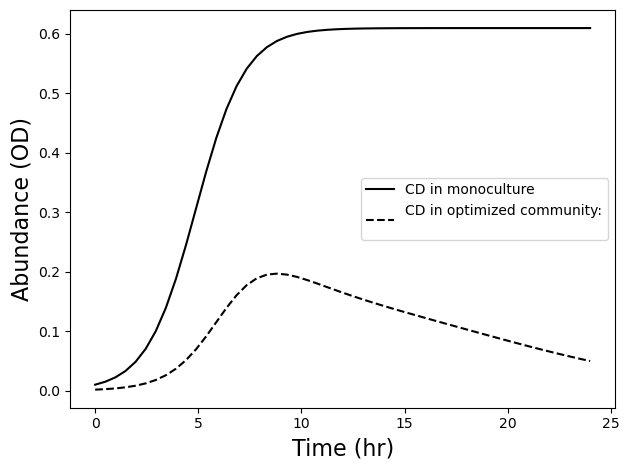

In [9]:
# compute strain specific objectives
mono_pred, mono_stdv = model.predict(X[0], t_eval)
strain_pred, strain_stdv = model.predict(X[np.argmin(objectives)], t_eval)

plt.plot(t_eval, mono_pred[:, cd_ind], label=f"CD in monoculture", color='k', linestyle='-')
#plt.fill_between(t_eval, full_pred[:,4]-full_stdv[:,4], full_pred[:,4]+full_stdv[:,4], color='k', alpha=0.2)

c_name = comm_name(sp_names[X[np.argmax(objectives)] > 0])
plt.plot(t_eval, strain_pred[:, cd_ind], label=f"CD in optimized community:\n{c_name}", color='k', linestyle='--')
#plt.fill_between(t_eval, strain_pred[:,4]-strain_stdv[:,4], strain_pred[:,4]+strain_stdv[:,4], color='k', alpha=0.2)

#plt.plot(t_eval, obj_pred[:,4], label=f"Robust", color='k', linestyle='-')
#plt.fill_between(t_eval, obj_pred[:,4]-obj_stdv[:,4], obj_pred[:,4]+obj_stdv[:,4], color='k', alpha=0.2)

plt.legend()
# plt.ylim([0, .3])

plt.xlabel("Time (hr)", fontsize=16)
plt.ylabel("Abundance (OD)", fontsize=16)
    
plt.tight_layout()
# plt.savefig("cd_inhibition.pdf", dpi=300)
plt.show()

In [10]:
# highlight 
# C1: CH-CS-DP + CD

In [11]:
sp_names

array(['CA', 'BT', 'BU', 'CS', 'CD', 'DP', 'CH', 'BV'], dtype=object)

In [12]:
comm1_inds = [3, 4, 5, 6]
species[comm1_inds]

array(['CS', 'CD', 'DP', 'CH'], dtype=object)

In [13]:
comm1_ind = np.argmax(np.sum(X[:, comm1_inds] > 0, 1))

In [14]:
objectives[comm1_ind]

0.28754833

In [15]:
# C2: BU-CA-DP + CD
comm2_inds = [0, 2, 4, 5]
species[comm2_inds]

array(['CA', 'BU', 'CD', 'DP'], dtype=object)

In [16]:
comm2_ind = np.argmax(np.sum(X[:, comm2_inds] > 0, 1))

In [17]:
objectives[comm2_ind]

0.17643313

In [18]:
comm_names = ["CD+"+comm_name(sp_names[x0 > 0]) for x0 in X]
richness = np.sum(X > 0, 1)
df_opt = pd.DataFrame()
df_opt["Comms"] = comm_names
df_opt["Richness"] = richness
df_opt["CD OD"] = objectives
df_opt.to_csv("opt/df_gLV_MS008_growth.csv", index=False)

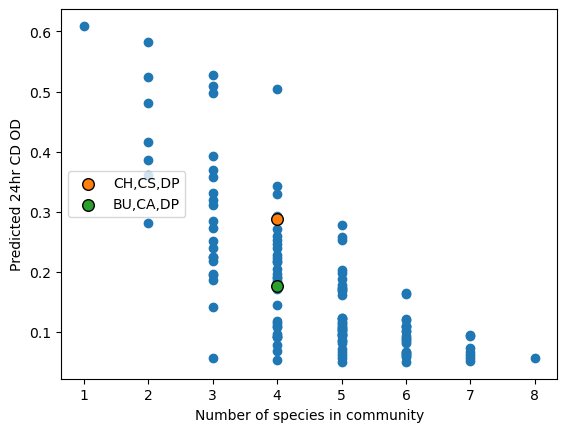

In [19]:
plt.scatter(np.sum(X > 0, 1), objectives)
plt.scatter(np.sum(X[comm1_ind]>0), objectives[comm1_ind], edgecolor='k', s=70, label="CH,CS,DP")
plt.scatter(np.sum(X[comm2_ind]>0), objectives[comm2_ind], edgecolor='k', s=70, label="BU,CA,DP")

plt.legend(loc='center left')
plt.xlabel("Number of species in community")
plt.ylabel("Predicted 24hr CD OD")
# plt.savefig("figures/CDreduction_vs_richness_DSM.pdf", dpi=300)
plt.show()